In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from imgaug import augmenters as iaa
sns.set(style="darkgrid", font_scale=1.0)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import io 
import pandas as pd

from tensorflow import keras
from keras.models import load_model
from keras.utils import plot_model
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras import models
import os
import cv2
from tqdm import tqdm
import random

from keras import backend as K

In [ ]:
train_location = 'drive/My Drive/STDL/downsized/train'
test_location = 'drive/My Drive/STDL/downsized/test'
train_list = []
test_list = []
img_cols, img_rows = 32, 32

# save train and test directories in a list, sorted alphabetically
for train_dir in os.listdir(train_location):
  train_list.append(train_dir)
train_list = sorted(train_list)
for test_dir in os.listdir(test_location):
  test_list.append(test_dir)
test_list = sorted(test_list)

# check if training list matches testing list
print(train_list == test_list)

True


In [ ]:
# prepare training data
train_location = 'drive/My Drive/STDL/downsized/train'
training_data = []
x_train = []
y_train = []

def create_train_data():
  for data in tqdm(train_list):
    path = os.path.join(train_location, data)
    class_num = train_list.index(data)
    
    # iterate over images by directories alphabetically
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img))  # convert to array
        new_array = cv2.resize(img_array, (img_cols, img_rows))  # resize to normalize data size
        training_data.append([new_array, class_num])  # add this to our training_list
      except Exception as e: 
        pass
  return training_data

training_data = create_train_data()

random.shuffle(training_data)
for features,label in training_data:
  x_train.append(features)
  y_train.append(label)
x_train = np.array(x_train).reshape(len(training_data), img_rows, img_cols, 3)
y_train = np.array(y_train).reshape(len(training_data))

# save data as numpy array
np.save('drive/My Drive/STDL/x_train.npy', x_train)
np.save('drive/My Drive/STDL/y_train.npy', y_train)

100%|██████████| 100/100 [12:17<00:00,  7.38s/it]


In [ ]:
# prepare testing data
test_location = 'drive/My Drive/STDL/downsized/test'
testing_data = []
x_test = []
y_test = []

def create_test_data():
  for data in tqdm(test_list):
    path = os.path.join(test_location, data)
    class_num = test_list.index(data)
    
    # iterate over images by directories alphabetically
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img))  # convert to array
        new_array = cv2.resize(img_array, (img_cols, img_rows))  # resize to normalize data size
        testing_data.append([new_array, class_num])  # add this to our testing_list
      except Exception as e: 
        pass
  return testing_data

testing_data = create_test_data()

for features,label in testing_data:
  x_test.append(features)
  y_test.append(label)
x_test = np.array(x_test).reshape(len(testing_data), img_rows, img_cols, 3)
y_test = np.array(y_test).reshape(len(testing_data))

# save data in numpy array
np.save('drive/My Drive/STDL/x_test.npy', x_test)
np.save('drive/My Drive/STDL/y_test.npy', y_test)

NameError: ignored

In [ ]:
img_width, img_height = 32, 32

# handle image format
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    
# image augmentation
seq = iaa.Sequential([
  iaa.Fliplr(0.5),
  iaa.Sometimes(
      0.5,
      iaa.GaussianBlur(sigma=(0, 0.5))
  )
], random_order=True)

# get cifar dataset for testing
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = keras.datasets.cifar10.load_data()

# load face dataset numpy array
x_train = np.load('drive/My Drive/STDL/x_train.npy')
y_train = np.load('drive/My Drive/STDL/y_train.npy')
x_test = np.load('drive/My Drive/STDL/x_test.npy')
y_test = np.load('drive/My Drive/STDL/y_test.npy')

# scaling dataset by pixels to range of [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0
x_test_cifar = x_test_cifar / 255.0

# append augmented images to dataset to increase dataset size
aug_img = seq.augment_images(x_train)
x_train = np.append(x_train, aug_img, axis=0)
y_train = np.append(y_train, y_train, axis=0)

# map label indices to class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
# calculate model prediction manually by comparing with ground truth
def cal_acc(model):
  predictions = model.predict(x_test_cifar)
  test_image = np.expand_dims(x_test_cifar, axis = 0) 
  arr = model.predict(test_image[0])

  true_predict = 0
  false_predict = 0

  for i in range (0, x_test_cifar.shape[0]):
    if y_test_cifar[i] == np.argmax(arr[i]):
      true_predict += 1
    else:
      false_predict += 1
  predict_acc = (true_predict / (true_predict + false_predict)) * 100
  print("Prediction accuracy: %.2f" %(predict_acc))
  return predict_acc

In [ ]:
# logging and history

# get model summary string to be saved as text file
def get_model_summary(model):
  stream = io.StringIO()
  model.summary(print_fn=lambda x: stream.write(x + '\n'))
  summary_string = stream.getvalue()
  stream.close()
  return summary_string

def logs(model_type, model, model_history, time_taken, test_acc):
  model_summary_string = get_model_summary(model)
  hist_df = pd.DataFrame(model_history.history)
  # predict_acc = cal_acc(model)

  # write history to log text file
  title = r'drive/My Drive/' + str(model_type) + str('_log.txt')
  file = open(title, 'w')
  file.write("Model summary: \n" + str(model_summary_string))
  file.write("Number of Epochs: %d, Batch Size: %d" %(epochs, batch_size))
  file.write("\n History: \n" + str(hist_df))
  file.write(str("\nTime taken: %.4f," %((time_taken)) + ' Test accuracy: {:5.2f}%'.format(100 * test_acc)))
  # file.write("\nPrediction accuracy on CIFAR-10: %.2f" %(predict_acc))
  file.close()
  print('logged for', model_type)

In [ ]:
# plot accuracy and loss graphs
def plot_graph(epochs_no, mode, train_model, type_):
  history = train_model.history
  history.keys()

  acc = history['accuracy']
  val_acc = history['val_accuracy']
  loss = history['loss']
  val_loss = history['val_loss']

  plt.title('Graph of loss/accuracy vs number of epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss/Accuracy')  
  if mode is 'train':
    plt.plot(epochs_no, loss, 'ro', label='Training loss')
    plt.plot(epochs_no, acc, 'bo', label='Training accuracy')
    title = 'drive/My Drive/' + str(type_) + 'model_train.png'
  elif mode is 'test':
    plt.plot(epochs_no, val_loss, 'r', label='Testing loss')
    plt.plot(epochs_no, val_acc, 'b', label='Testing accuracy')   
    title = 'drive/My Drive/' + str(type_) + 'model_test.png' 
  plt.legend()
  plt.savefig(title)
  plt.show()

In [ ]:
# load trained VGG16 model
model = keras.models.load_model('drive/My Drive/STDL/Q1/teacher_network/model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1, 1, 512)         14718528  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4096)              2101248   
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
logits (Dense)               (None, 10)                40970     
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 33,642,058
Trainable params: 33,640,138
Non-trainable params: 1,920
______________________________________

In [ ]:
# set hyperparameters
epochs = 100
batch_size = 64
lrate = 0.001
decay = lrate/epochs

lrr= tf.keras.callbacks.ReduceLROnPlateau(
                       monitor='val_accuracy', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5)

loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
adam1 = tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
adam = tf.keras.optimizers.Adam(lr=1e-7, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9, nesterov=False) 
sgd1 = tf.keras.optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False) 

In [ ]:
# compile model and start training
def train_model(model_type, model_):
  model_.compile(optimizer=adam, loss=loss_func, metrics=['accuracy'])
  model_name = model_type + str('_model.h5')

  start_time = time.time()
  model_train = model_.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), steps_per_epoch=x_train.shape[0]//batch_size, batch_size=batch_size, callbacks=[lrr], shuffle=True)
  time_taken = time.time() - start_time
  print('Time taken for %d epochs: %.4f' % (epochs, time_taken))

  # evaluate model
  test_loss, test_acc = model_.evaluate(x_test, y_test)
  print('Test accuracy: {:5.2f}%'.format(100 * test_acc))

  model.save(model_name)
  print('Model saved.')

  epochs_no = range(1, epochs + 1)
  # logs and plotting graph
  logs(model_type, model_, model_train, time_taken, test_acc)
  plot_graph(epochs_no, 'train', model_train, model_type)
  plot_graph(epochs_no, 'test', model_train, model_type)

In [ ]:
# Feature Extraction

In [ ]:
# feature extraction model
def ext_model(model):
  ext_model = keras.Sequential()   
  for layer in model.layers[:-1]:
    ext_model.add(layer)

  # add final layer and set layer to be trainable
  ext_model.add(keras.layers.Dense(100, trainable=True, activation=tf.nn.softmax))
  
  return ext_model

ext_model = ext_model(model)
ext_model.summary()
train_model('Feature_Extraction', ext_model)

In [ ]:
# Fine Tuning

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense_6 (Dense)              (None, 4096)              268439552 
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_8 (Dense)              (None, 100)               409700    
Total params: 285,649,956
Trainable params: 285,649,956
Non-trainable params: 0
________________________________________

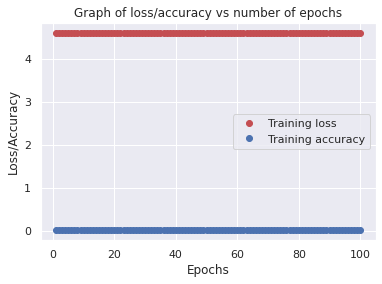

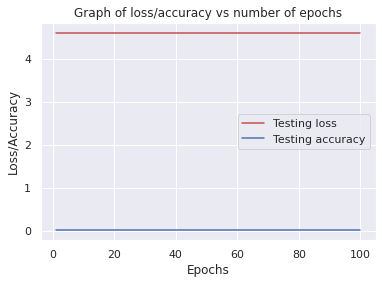

In [ ]:
# fine tuning model
def ft_model(model):
  ft_model = keras.Sequential()   
  ft_model.add(keras.layers.Input(shape=(32, 32, 3), name='main_inputs'))
  ft_model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
  ft_model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  for layer in model.layers[1:-4]:
    layer.trainable=True
    ft_model.add(layer)   

  # add final layer and set layer to be trainable
  # ft_model.add(keras.layers.ZeroPadding2D(padding=(1, 1))),
  # ft_model.add(keras.layers.Conv2D(filters=512, kernel_size=1, padding='same', activation='relu')),
  # ft_model.add(keras.layers.Conv2D(filters=512, kernel_size=1, padding='same', activation='relu')),
  # ft_model.add(keras.layers.MaxPooling2D(pool_size=(2,2), padding='same', strides=2)),
  # ft_model.add(keras.layers.GlobalAveragePooling2D()),
  # ft_model.add(keras.layers.Flatten()),
  ft_model.add(keras.layers.Dense(4096, trainable=True, activation=tf.nn.softmax))
  ft_model.add(keras.layers.Dense(4096, trainable=True, activation=tf.nn.softmax))
  ft_model.add(keras.layers.Dense(100, trainable=True, activation=tf.nn.softmax))

  # for layer in ft_model.layers[0:-4]:
  #   layer.trainable = False
  
  return ft_model

ft_model = ft_model(model)
ft_model.summary()
train_model('Fine_Tuning', ft_model)

In [ ]:
# LWF

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1, 1, 512)         14718528  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4096)              2101248   
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_8 (Dense)              (None, 100)               409700    
Total params: 34,010,788
Trainable params: 409,700
Non-trainable params: 33,601,088
_________________________________________________________________
Epoch 1/100
62/62 [==============================] - 1s 19ms/step - loss: 4.6057 - accuracy: 0.0066 -

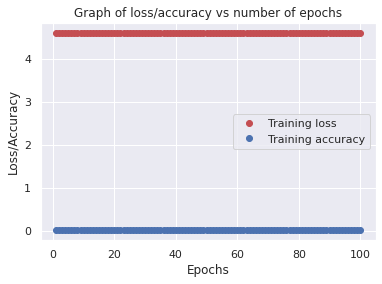

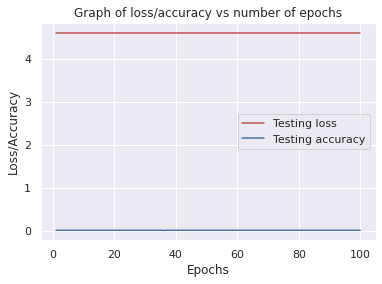

In [ ]:
# randomly initialize weights, then train weights with frozen parameters (warming step)
def warm_model(model):
  warm_model = keras.Sequential()   
  for layer in model.layers[:-2]:
    layer.kernel_initializer=keras.initializers.RandomNormal(stddev=0.01)
    layer.trainable=False
    warm_model.add(layer)

  # add final layer and set layer to be trainable
  warm_model.add(keras.layers.Dense(100, trainable=True, activation=tf.nn.softmax, kernel_initializer=keras.initializers.RandomNormal(stddev=0.01)))
  
  return warm_model

warm_model = warm_model(model)
warm_model.summary()
# train_model('Warming', warm_model)

# compile and train model
warm_model.compile(optimizer=adam, loss=loss_func, metrics=['accuracy'])

start_time = time.time()
warm_train = warm_model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), steps_per_epoch=x_train.shape[0]//batch_size, batch_size=batch_size, callbacks=[lrr], shuffle=True)
time_taken = time.time() - start_time
print('Time taken for %d epochs: %.4f' % (epochs, time_taken))

# evaluate model
test_loss, test_acc = warm_model.evaluate(x_test, y_test)
print('Test accuracy: {:5.2f}%'.format(100 * test_acc))

model.save('drive/My Drive/STDL/warming_model.h5')
print('Model saved.')

epochs_no = range(1, epochs + 1)
# logs and plotting graph
logs('Warming', warm_model, warm_train, time_taken, test_acc)
plot_graph(epochs_no, 'train', warm_train, 'Warming')
plot_graph(epochs_no, 'test', warm_train, 'Warming')

In [ ]:
# load warming model to train old and new task simultaneously (LWF)
warming_model = keras.models.load_model('drive/My Drive/STDL/warming_step/warming_model.h5')
warming_model.trainable=True
model = keras.Sequential()   
for layer in warming_model.layers[:-2]:
  model.add(layer)

# add final layer and initialize with L2 norm
model.add(keras.layers.Dense(100, trainable=True, activation=tf.nn.softmax, kernel_regularizer=regularizers.l1_l2(l1=0.0005, l2=0.0005),
    bias_regularizer=regularizers.l2(0.0005),
    activity_regularizer=regularizers.l2(0.0005)))

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1, 1, 512)         14718528  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4096)              2101248   
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_11 (Dense)             (None, 100)               409700    
Total params: 34,010,788
Trainable params: 34,008,868
Non-trainable params: 1,920
_________________________________________________________________


In [ ]:
# distillation class taken from Keras documentation
from sklearn.preprocessing import Normalizer

class Distiller(keras.Model):
    def __init__(self, lwf_):
        super(Distiller, self).__init__()
        self.lwf_ = lwf_

    def compile(
        self,
        optimizer,
        metrics,
        old_loss_fn,
        new_loss_fn,
        test_loss_fn,
        alpha,
        temperature,
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.old_loss_fn = old_loss_fn
        self.new_loss_fn = new_loss_fn
        self.test_loss_fn = test_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data
        old_predict = self.lwf_(x, training=False)        
        alpha = self.alpha

        with tf.GradientTape() as tape:     
            new_predict = self.lwf_(x, training=True)
            y_o = tf.math.pow(old_predict, (1/self.temperature))
            y_o_hat = self.lwf_(x, training=True)

            # Compute losses
            old_loss = self.old_loss_fn(tf.math.argmax(y_o, axis=1), y_o_hat)
            new_loss = self.new_loss_fn(y, new_predict)           
            test_loss = self.test_loss_fn(
                tf.nn.softmax(new_predict / self.temperature, axis=1),
                tf.nn.softmax(old_predict / self.temperature, axis=1),
            )
            loss = (alpha * old_loss) + new_loss

        # Compute gradients
        trainable_vars = self.lwf_.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, new_predict)
        self.compiled_metrics.update_state(tf.math.argmax(y_o_hat, axis=1), old_predict)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"loss": loss, "val_loss": test_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.lwf_(x, training=False)

        # Calculate the loss
        test_loss = self.new_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"val_loss": test_loss})
        return results


In [ ]:
# plot accuracy and loss graphs
def plot_graph1(epochs_no, mode, train_model, type_):
  history = train_model.history
  history.keys()

  test_acc = history['sparse_categorical_accuracy']
  train_loss = history['loss']
  test_loss = history['val_loss']

  plt.title('Graph of training/testing loss vs number of epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss/Accuracy')  
  if mode is 'loss':
    graph_ = 'Graph of train/test loss vs number of epochs'
    y_axis = 'Loss'
    plt.plot(epochs_no, train_loss, 'r', label='Training loss')
    plt.plot(epochs_no, test_loss, 'b', label='Testing loss')
    title = 'drive/My Drive/test_loss.png'
  elif mode is 'accuracy':
    graph_ = 'Graph of test accuracy vs number of epochs'
    y_axis = 'Accuracy'
    plt.plot(epochs_no, test_acc, 'g', label='Testing accuracy')
    title = 'drive/My Drive/test_acc.png' 
  plt.legend()
  plt.savefig(title)
  plt.show()

Epoch 1/100
125/125 [==============================] - 9s 69ms/step - sparse_categorical_accuracy: 0.5050 - loss: 4.9743 - val_loss: 4.1117e-11
Epoch 2/100
125/125 [==============================] - 9s 70ms/step - sparse_categorical_accuracy: 0.5050 - loss: 4.9745 - val_loss: 3.9391e-10
Epoch 3/100
125/125 [==============================] - 9s 70ms/step - sparse_categorical_accuracy: 0.5050 - loss: 4.9743 - val_loss: 1.7330e-09
Epoch 4/100
125/125 [==============================] - 9s 70ms/step - sparse_categorical_accuracy: 0.5050 - loss: 4.9745 - val_loss: 1.2743e-09
Epoch 5/100
125/125 [==============================] - 9s 69ms/step - sparse_categorical_accuracy: 0.5050 - loss: 4.9745 - val_loss: 2.5480e-10
Epoch 6/100
125/125 [==============================] - 9s 69ms/step - sparse_categorical_accuracy: 0.5050 - loss: 4.9745 - val_loss: -4.3981e-10
Epoch 7/100
125/125 [==============================] - 9s 69ms/step - sparse_categorical_accuracy: 0.5050 - loss: 4.9745 - val_loss: 1.

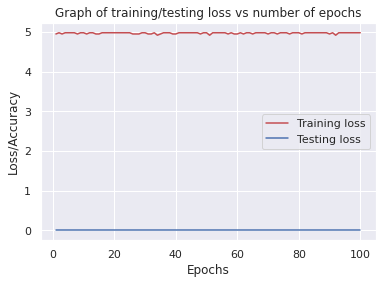

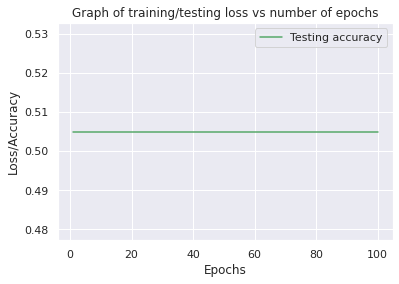

In [ ]:
# compile distiller model and start training
sgd = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9, nesterov=False) 

distiller = Distiller(lwf_=model)
distiller.compile(
    optimizer=sgd,
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    old_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    new_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    test_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10
)

start_time = time.time()
lwf_train = distiller.fit(x_train, y_train, epochs=epochs)
time_taken = time.time() - start_time

distiller.save_weights('drive/My Drive/STDL/lwf_model.h5')

# Evaluate LWF model on test dataset
distiller.evaluate(x_test, y_test)
epochs_no = range(1, epochs + 1)

# # logs and plotting graph
# # logs('LWF', distiller, lwf_train, time_taken, test_acc)
plot_graph1(epochs_no, 'loss', lwf_train, 'LWF')
plot_graph1(epochs_no, 'accuracy', lwf_train, 'LWF')

In [ ]:
# distiller.evaluate(x_test, y_test)
# distiller.save_weights('drive/My Drive/STDL/lwf_model.h5')
print('Model saved.')
distiller = Distiller(lwf_=model)
distiller.build((input_shape))
distiller.load_weights('drive/My Drive/STDL/lwf/lwf_model.h5')

print(cal_acc(lwf_model))

Model saved.


NotImplementedError: ignored